In [4]:
%matplotlib inline

import numpy as np
import pylab as plt
import ccgpack as ccg
from itertools import product
from matplotlib.colors import LogNorm

In [5]:
cl = np.load('../data/cl_planck_lensed.npy')
sfs = ccg.StochasticFieldSimulator(cl)
nside = 1024
size = 30
ms = []

In [6]:
for i in range(4):
    ms.append(sfs.simulate(nside,size))

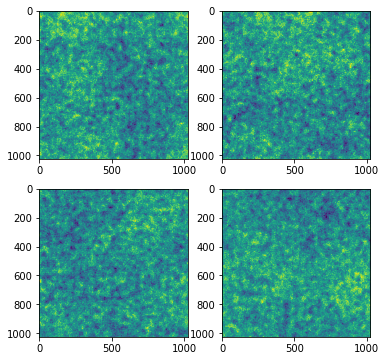

In [7]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(ncols=2
                            ,nrows=2,figsize=(6 ,6))
ax1.imshow(ms[0])
ax2.imshow(ms[1])
ax3.imshow(ms[2])
ax4.imshow(ms[3])

In [8]:
# ll0 = cl[:600,0]
# dl0 = cl[:600,1]*(ll0[:600]*(ll0[:600]+1)/(2*np.pi))
# ll,p1 = ccg.power_spectrum(ms[0],size=15)
# plt.plot(ll0,dl0,'k--')
# plt.plot(ll[:600],p1[:600],'b')
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(2,600)
# # plt.ylim(5e-8,5e4)


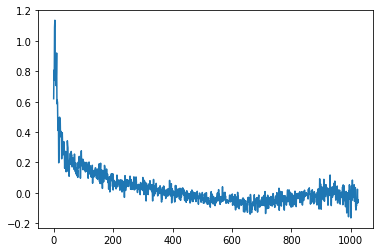

In [9]:
cor,ecor = ccg.correlarion_fucntion(ms[0],n_p=1e6)
plt.plot(cor)

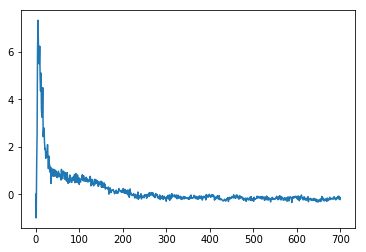

In [10]:
ksi = ccg.ppcf(ms[0],2,1e6,700)
plt.plot(ksi)

In [11]:
def N1(d,num=100,gt=True):
    nu = np.linspace(d.min(),d.max(),num)
    n1 = []
    for i in nu:
        if gt:
            n1.append(np.mean(d>i))
        else:
            n1.append(np.mean(d<i))
    n1 = np.array(n1)
    return nu,n1

def exterma(arr,peak=True):
    
    dim = len(arr.shape)       # number of dimensions
    offsets = [0, -1, 1]     # offsets, 0 first so the original entry is first 
    filt = np.ones(arr.shape,dtype=np.int8)
    for shift in product(offsets, repeat=dim):
        if np.all(np.array(shift)==0):
            continue
    #    print(shift)
    #    print(np.roll(b, shift, np.arange(dim)))
        rolled = np.roll(arr, shift, np.arange(dim))
        
        if peak:
            filt = filt*(arr>rolled)
        else:
            filt = filt*(arr<rolled)
            
    return filt  

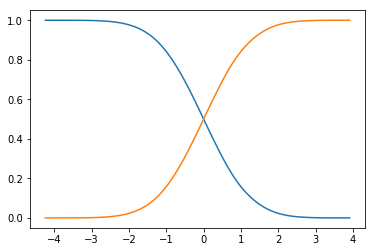

In [12]:
ms[0] = ms[0]-ms[0].mean()
ms[0] = ms[0]/ms[0].std()
nu,n1_gt = N1(ms[0],num=100,gt=True)
plt.plot(nu,n1_gt)

ms[0] = ms[0]-ms[0].mean()
ms[0] = ms[0]/ms[0].std()
nu,n1_lt = N1(ms[0],num=100,gt=False)
plt.plot(nu,n1_lt)

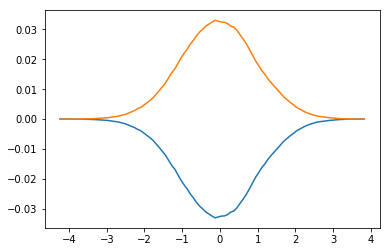

In [13]:
plt.plot(nu[:-1],np.diff(n1_gt))
plt.plot(nu[:-1],np.diff(n1_lt))

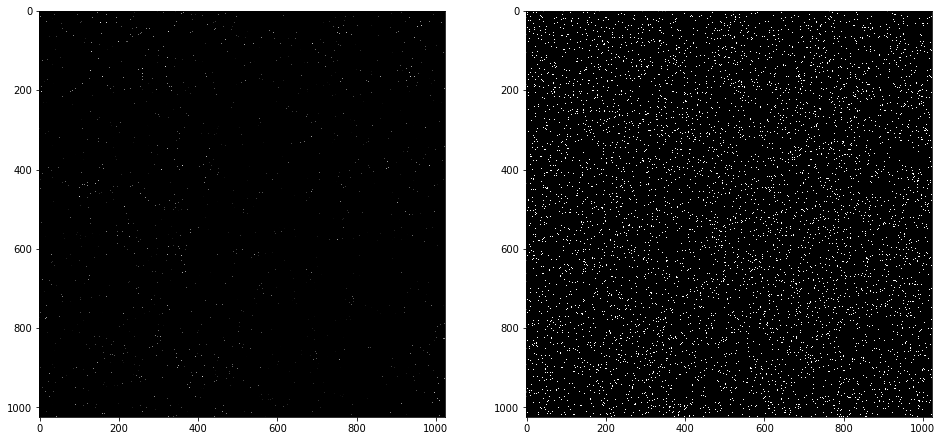

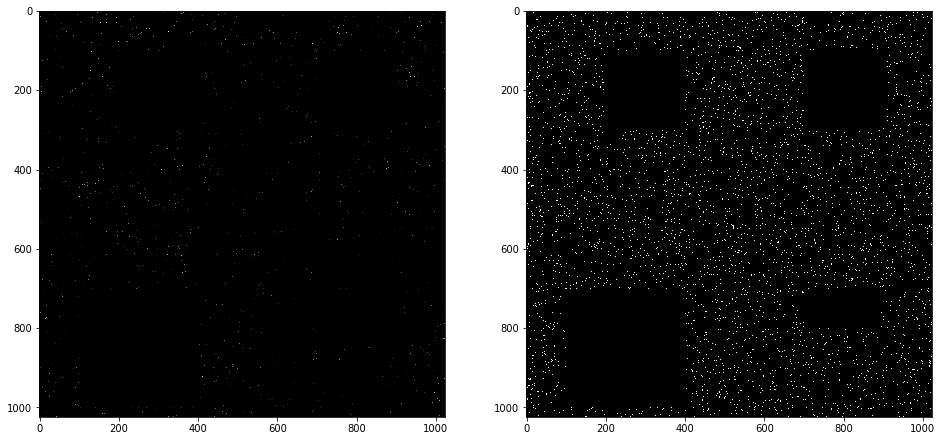

In [14]:
th = 0

mcopy = ms[0]+0
peaks = exterma(mcopy ,peak=True)
mcopy[np.logical_not(peaks.astype(bool))] = 0

mcopy[mcopy<th] = 0

nf1 = np.argwhere(mcopy).T
nnn = 5*nf1.shape[1]
rlist = np.random.randint(0,1024,(2,nnn))

ksi1 = ccg.ffcf_no_random(fl1=nf1, fl2=nf1, rlist=rlist, rmax=700)
# plt.plot(ksi1)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,8))
ax1.imshow(mcopy,cmap='gray')
rimg = np.zeros(mcopy.shape)
rows, cols = zip(*rlist.T)
rimg[rows, cols] = 1
ax2.imshow(rimg,cmap='gray')

mask = np.zeros(ms[0].shape)+1
mask[700:1000,100:400] = 0
mask[100:300,700:900] = 0
mask[100:300,200:400] = 0
mask[700:800,700:890] = 0

mcopy = ms[0]*mask+0
peaks = exterma(mcopy ,peak=True)
mcopy[np.logical_not(peaks.astype(bool))] = 0

mcopy[mcopy<th] = 0

nf1 = np.argwhere(mcopy).T

nnn = 5*nf1.shape[1]

rlist = np.random.randint(0,1024,(nnn,2))
rimg = np.zeros(mcopy.shape)
rows, cols = zip(*rlist)
rimg[rows, cols] = 1
rimg = rimg*mask
rlist = np.argwhere(rimg).T

ksi2 = ccg.ffcf_no_random(fl1=nf1, fl2=nf1, rlist=rlist, rmax=700)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,8))
ax1.imshow(mcopy,cmap='gray')
ax2.imshow(rimg,cmap='gray')

rlist = np.random.randint(0,1024,(2,nnn))
ksi3 = ccg.ffcf_no_random(fl1=nf1, fl2=nf1, rlist=rlist, rmax=700)



ksi4 = eval_ksi(ms[0],mask,thresholds=[0],peak=True)[0]     
    


# plt.plot(ksi)

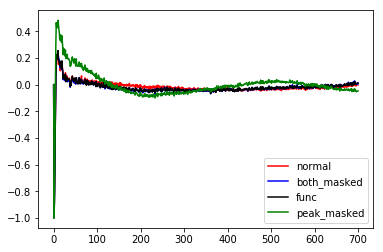

In [17]:
plt.plot(ksi1,'r',label='normal')
plt.plot(ksi2,'b',label='both_masked')

plt.plot(ksi4,'k',label='func')

plt.plot(ksi3,'g',label='peak_masked')



plt.legend()
plt.savefig('tpcf.jpg',dpi=150)

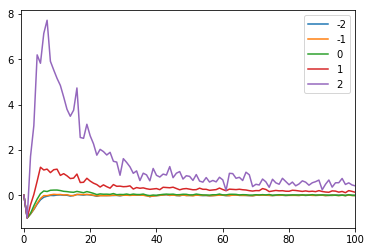

In [23]:
# thresholds = [-2,-1,0,1,2]
# ksis = eval_ksi(ms[0],mask,thresholds,peak=True,rmax=700,crand=5)

for i in range(len(ksis)):
    plt.plot(ksis[i],label=str(thresholds[i]))
    
plt.xlim(-1,100)
plt.legend()

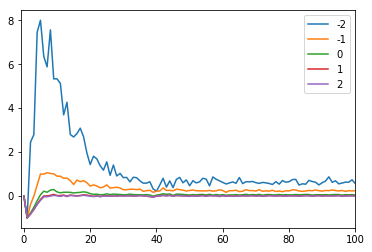

In [24]:
thresholds = [-2,-1,0,1,2]
ksis = eval_ksi(ms[0],mask,thresholds,peak=False,rmax=700,crand=5)

for i in range(len(ksis)):
    plt.plot(ksis[i],label=str(thresholds[i]))
    
plt.xlim(-1,100)
plt.legend()

In [20]:

def eval_ksi(m,mask,thresholds,peak=True,rmax=700,crand=5):

    ksis = []
    
    mc1 = m*mask
    nside = mc1.shape[0]
    peaks = exterma(mc1 ,peak=peak)
    mc1[np.logical_not(peaks.astype(bool))] = 0

    for th in thresholds:
        mc2 = mc1+0
        if peak:
            mc2[mc2<th] = 0
        else:
            mc2[mc2>th] = 0

        nf1 = np.argwhere(mc2).T
        nnn = crand*nf1.shape[1]
        rlist = np.random.randint(0,nside,(nnn,2))
        rimg = np.zeros(mc2.shape)
        rows, cols = zip(*rlist)
        rimg[rows, cols] = 1
        rimg = rimg*mask
        rlist = np.argwhere(rimg).T

        ksis.append(ccg.ffcf_no_random(fl1=nf1, fl2=nf1, rlist=rlist, rmax=rmax))
        
    return ksis
        
    


In [104]:
# def bias(m,ths,kmin,kmax):
    
#     if not isinstance(ths, list):
#         ths = [ths]
    
#     bs = []
#     for th in ths:
#         ksi = ccg.ppcf(m,th,1e6,700)
#         biask = np.sqrt(np.absolute(ksi[:700]/cor[:700]))

#         bs.append(np.mean(biask[kmin:kmax]))
              
#     return bs

In [103]:
# ths = [0.5,1.0,1.5,2.0,2.5]

# kmin = 10
# kmax = 50

# bs = bias(ms[0],ths,kmin,kmax)

# bsth = np.array(ths)
# plt.plot(ths,bsth,'r--')

# plt.plot(ths,bs,'bo')

# plt.xlabel(r'$\nu$',fontsize=15)
# plt.ylabel(r'$b(\nu)$',fontsize=15)